In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from scipy.spatial.distance import euclidean
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
##plotting
import project3_plotting as p3_plot

Using TensorFlow backend.


# Import, clean, and preprocess data

In [2]:
diabetes = pd.read_csv('diabetic_data.csv')
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Data Cleaning

In [3]:
diabetes.replace('?', np.NaN, inplace=True)

In [4]:
for col in diabetes:
    print("Unique values for feature {0} :".format(col), diabetes[col].nunique())
    print("The number of null values:", diabetes[col].isnull().sum() )

Unique values for feature encounter_id : 101766
The number of null values: 0
Unique values for feature patient_nbr : 71518
The number of null values: 0
Unique values for feature race : 5
The number of null values: 2273
Unique values for feature gender : 3
The number of null values: 0
Unique values for feature age : 10
The number of null values: 0
Unique values for feature weight : 9
The number of null values: 98569
Unique values for feature admission_type_id : 8
The number of null values: 0
Unique values for feature discharge_disposition_id : 26
The number of null values: 0
Unique values for feature admission_source_id : 17
The number of null values: 0
Unique values for feature time_in_hospital : 14
The number of null values: 0
Unique values for feature payer_code : 17
The number of null values: 40256
Unique values for feature medical_specialty : 72
The number of null values: 49949
Unique values for feature num_lab_procedures : 118
The number of null values: 0
Unique values for feature

Remove features that are mostly missing / unique to patients
1. encounter_id - unique to each instance
2. patient_number - unique to each patient
3. weight - missing for 97% of the dataset
4. payer_code - which insurance the patient had. Missing for 52% of dataset
5. medical_specialty - speciality of admitted physician. Missing for 53 % of data

In [5]:
drop_cols = ['encounter_id','patient_nbr','weight','payer_code','medical_specialty']
diabetes.drop(drop_cols, axis=1, inplace=True)

In [6]:
#Since the nulls in each column take up a very small portion of the data, just fill with most common value
cols = diabetes.columns.values
diabetes[cols]=diabetes[cols].fillna(diabetes.mode().iloc[0])

In [7]:
## format age feature. 0 maps to [0-10), 1 maps tp [10,20)...etc
diabetes['age'] = diabetes['age'].str[1]

In [8]:
## Female is the most common entry for gender
diabetes.loc[diabetes['gender'] == 'Unknown/Invalid', 'gender'] = 'Female'

In [9]:
diags = ['diag_1','diag_2','diag_3']
for diag in diags:
    print('feature:', diabetes[diag].value_counts().head(5))

feature: 428    6883
414    6581
786    4016
410    3614
486    3508
Name: diag_1, dtype: int64
feature: 276    7110
428    6662
250    6071
427    5036
401    3736
Name: diag_2, dtype: int64
feature: 250    12978
401     8289
276     5175
428     4577
427     3955
Name: diag_3, dtype: int64


In [10]:
diabetes.loc[(diabetes.diag_1 != '428') | (diabetes.diag_1 != '414') | (diabetes.diag_1 != '786') |
             (diabetes.diag_1 != '410') | (diabetes.diag_1 != '486'), 'diag_1'] = 'Other'

In [11]:
diabetes.loc[(diabetes.diag_2 != '276') | (diabetes.diag_2 != '428') | (diabetes.diag_2 != '250') |
             (diabetes.diag_2 != '427') | (diabetes.diag_2 != '401'), 'diag_2'] = 'Other'

In [12]:
diabetes.loc[(diabetes.diag_3 != '250') | (diabetes.diag_3 != '401') | (diabetes.diag_3 != '276') |
             (diabetes.diag_3 != '428') | (diabetes.diag_3 != '407'), 'diag_3'] = 'Other'

In [13]:
label_cols = ['race','gender', 'diag_1','diag_2','diag_3']

starting = diabetes.columns.get_loc('max_glu_serum')
ending = diabetes.columns.size

feature_cols = diabetes.columns.values[starting:ending].tolist()
for features in label_cols:
    feature_cols.append(features)


In [14]:
# One label encoding for all catagorical data.
diabetes[feature_cols] = diabetes[feature_cols].apply(LabelEncoder().fit_transform)

In [15]:
diabetes.sample(10)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
76504,2,1,7,1,1,7,2,47,0,11,...,0,1,1,0,0,0,0,1,0,1
8639,2,1,7,6,1,17,6,45,2,10,...,0,1,1,0,0,0,0,1,1,1
82593,2,0,5,3,1,1,4,13,1,16,...,0,2,1,0,0,0,0,0,1,2
86565,2,1,6,1,1,7,1,2,0,6,...,0,1,1,0,0,0,0,1,0,2
4340,2,0,7,2,1,4,2,1,3,14,...,0,1,1,0,0,0,0,1,1,2
18034,2,1,7,2,1,1,10,48,1,19,...,0,1,1,0,0,0,0,1,0,2
95718,2,1,7,1,1,7,4,29,3,13,...,0,1,1,0,0,0,0,1,1,2
77722,0,0,8,1,3,7,5,60,0,11,...,0,2,1,0,0,0,0,1,1,2
60829,1,1,7,1,1,7,2,35,1,6,...,0,1,1,0,0,0,0,1,0,2
31803,2,0,1,1,1,6,2,58,0,8,...,0,2,1,0,0,0,0,1,1,2


In [16]:
# drop output
y_diabetes = diabetes['readmitted']
X = diabetes.drop('readmitted', axis=1)

# scale input
X_diabetes_scaled = scale(X)

## For time, selecting 20% of this data
diabetes_x, _, diabetes_y, _ = train_test_split(X_diabetes_scaled, y_diabetes, test_size=0.9, random_state=42)

In [17]:
diabetes_x

array([[ 0.39147429,  1.07828717,  1.19398187, ..., -0.00313473,
        -1.07922537,  0.54648751],
       [ 0.39147429, -0.92739673,  0.56665918, ..., -0.00313473,
        -1.07922537,  0.54648751],
       [-1.95115613, -0.92739673, -0.06066351, ..., -0.00313473,
        -1.07922537,  0.54648751],
       ..., 
       [ 0.39147429,  1.07828717,  0.56665918, ..., -0.00313473,
        -1.07922537,  0.54648751],
       [ 0.39147429, -0.92739673, -0.06066351, ..., -0.00313473,
        -1.07922537,  0.54648751],
       [ 0.39147429, -0.92739673, -1.31530888, ..., -0.00313473,
        -1.07922537,  0.54648751]])

Mice Data

In [18]:
mice = pd.read_csv('Data_Cortex_Nuclear.csv')
mice.head()

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


Drop volumns that are unique or indentifying information (not relevant data)
1. MouseID
2. Genotype
3. Treatment
4. Behavior

In [19]:
drop_cols = ['MouseID','Genotype','Treatment','Behavior']
mice.drop(drop_cols, axis=1, inplace=True)

In [20]:
## look for nans
for col in mice:
    print(col)
    print("The number of null values:", mice[col].isnull().sum() )

DYRK1A_N
The number of null values: 3
ITSN1_N
The number of null values: 3
BDNF_N
The number of null values: 3
NR1_N
The number of null values: 3
NR2A_N
The number of null values: 3
pAKT_N
The number of null values: 3
pBRAF_N
The number of null values: 3
pCAMKII_N
The number of null values: 3
pCREB_N
The number of null values: 3
pELK_N
The number of null values: 3
pERK_N
The number of null values: 3
pJNK_N
The number of null values: 3
PKCA_N
The number of null values: 3
pMEK_N
The number of null values: 3
pNR1_N
The number of null values: 3
pNR2A_N
The number of null values: 3
pNR2B_N
The number of null values: 3
pPKCAB_N
The number of null values: 3
pRSK_N
The number of null values: 3
AKT_N
The number of null values: 3
BRAF_N
The number of null values: 3
CAMKII_N
The number of null values: 3
CREB_N
The number of null values: 3
ELK_N
The number of null values: 18
ERK_N
The number of null values: 3
GSK3B_N
The number of null values: 3
JNK_N
The number of null values: 3
MEK_N
The number 

The data set consists of the expression levels of 77 proteins/protein modifications that produced detectable signals in the nuclear fraction of cortex. I will make the asssumption that NaN represented a non detectable signal and will assigen them to 0

In [21]:
mice.fillna(0, inplace=True)

In [22]:
# drop output
y_mice = mice['class']
x_mice = mice.drop('class', axis=1)

# scale input
x_mice_scaled = scale(x_mice)

x_mice_scaled

array([[ 0.31618416,  0.52042534,  2.15027235, ..., -0.19417158,
        -0.25611341,  1.06590091],
       [ 0.36009334,  0.290904  ,  1.79683383, ..., -0.15328958,
        -0.2271027 ,  1.28029118],
       [ 0.33834925,  0.45351344,  1.92239433, ..., -0.17477542,
        -0.2635763 ,  1.85703831],
       ..., 
       [-0.78400393, -0.86947905, -1.61470117, ...,  1.00779164,
         1.989372  ,  0.29352469],
       [-0.81384366, -0.79953248, -1.42543115, ...,  1.28079644,
         2.08966612,  0.2089962 ],
       [-0.4881888 , -0.60935676, -1.18365644, ...,  1.30150693,
         2.08892271,  0.10478825]])

# K means

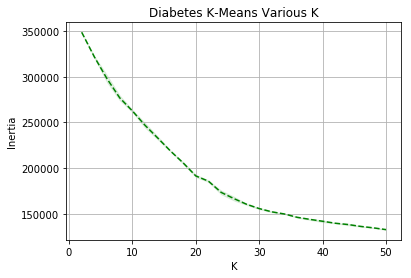

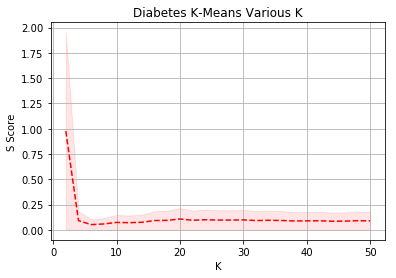

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [26]:
p3_plot.plot_various_k('Diabetes K-Means Various K',diabetes_x, min_k=2, max_k=50, step_size=25)

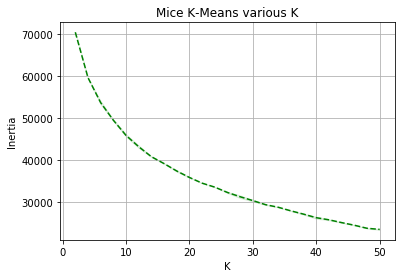

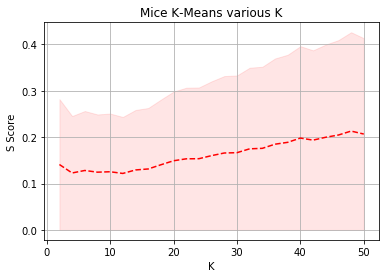

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [25]:
p3_plot.plot_various_k('Mice K-Means various K', x_mice_scaled, min_k=2, max_k=50, step_size=25)

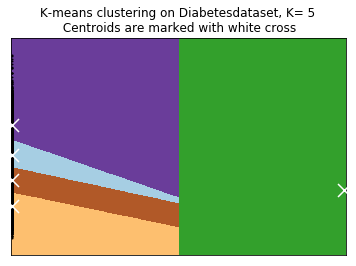

In [26]:
p3_plot.plot_kmeans_1('Diabetes',diabetes_x,5)

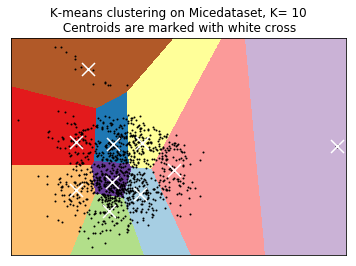

In [23]:
p3_plot.plot_kmeans_1('Mice',x_mice_scaled,10)

# EM

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

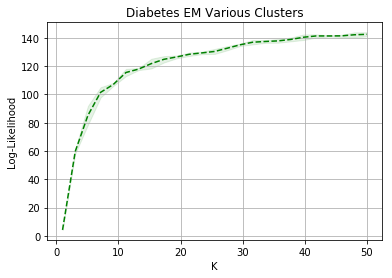

In [27]:
p3_plot.plot_various_k_EM('Diabetes EM Various Clusters', diabetes_x, min_k=1, max_k=50, step_size=25)

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

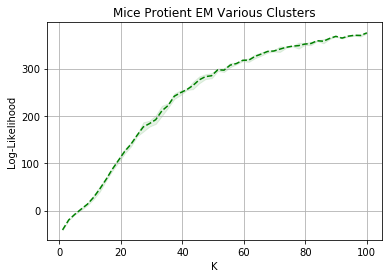

In [24]:
p3_plot.plot_various_k_EM('Mice Protient EM Various Clusters', x_mice_scaled,min_k=1, max_k=100, step_size=50)

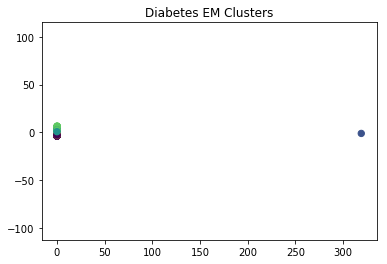

In [28]:
p3_plot.plot_gmm('Diabetes EM Clusters',GaussianMixture(n_components=5), diabetes_x)

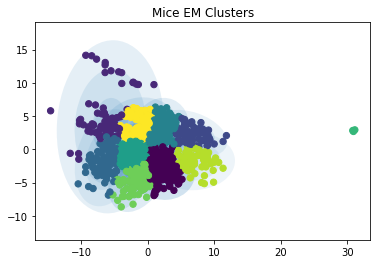

In [26]:
p3_plot.plot_gmm('Mice EM Clusters',GaussianMixture(n_components=10),x_mice_scaled)

# PCA

In [23]:
## first applying PCA with orginal number of features
diabetes_x.shape
pca = PCA(n_components=44)
pca.fit(diabetes_x)

PCA(copy=True, iterated_power='auto', n_components=44, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
eigeVectors = pca.components_
eigenValues = pca.explained_variance_

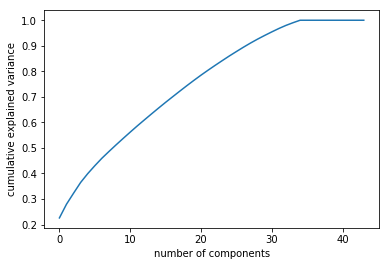

In [25]:
p3_plot.pca_num_components_plot(pca)

In [34]:
np.cumsum(pca.explained_variance_ratio_[0:28]) # first 29 components

array([ 0.22602342,  0.27971189,  0.3228614 ,  0.36496861,  0.3994008 ,
        0.43035359,  0.45964799,  0.48613059,  0.5119536 ,  0.5371257 ,
        0.56188593,  0.58623311,  0.6097104 ,  0.63301061,  0.65598461,
        0.67855072,  0.70045902,  0.7222645 ,  0.74371589,  0.76460708,
        0.78494569,  0.80441303,  0.82336313,  0.84180861,  0.86001906,
        0.87738803,  0.89446495,  0.91074233])

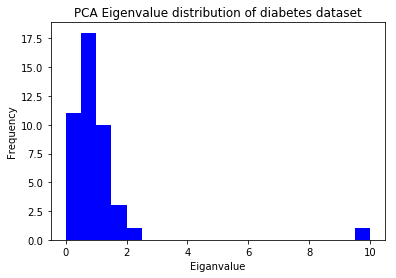

In [26]:
p3_plot.plot_eigenvalue_distribution(eigenValues,20)

In [36]:
def plot_various_PCA(data, maxFeatures, steps):
    comps = np.linspace(2,maxFeatures, steps)
    for i in comps:
        print('applying PCA')
        pca = PCA(n_components= int(i))
        trans = pca.fit_transform(data)
        print('applying TSNE')
        tsne = TSNE(2, init='pca', random_state=0, verbose=1, n_iter=250)
        Y = tsne.fit_transform(trans)
        print('plotting')
        plt.figure()
        plt.title(('PCA reduced to ',int(i), 'comps'))
        plt.scatter(Y[:, 0], Y[:, 1],cmap=plt.cm.Spectral)
        plt.show()

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.004s...
[t-SNE] Computed neighbors for 10176 samples in 0.269s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 0.011431
[t-SNE] KL divergence after 250 iterations with early exaggera

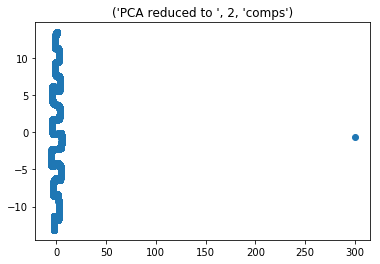

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.006s...
[t-SNE] Computed neighbors for 10176 samples in 2.797s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 0.702892
[t-SNE] KL divergence after 250 iterations with early exaggera

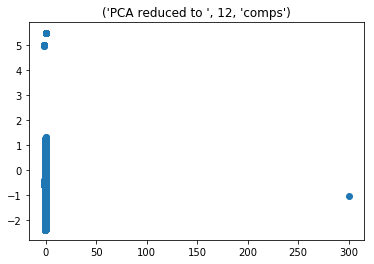

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.013s...
[t-SNE] Computed neighbors for 10176 samples in 4.433s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.014445
[t-SNE] KL divergence after 250 iterations with early exaggera

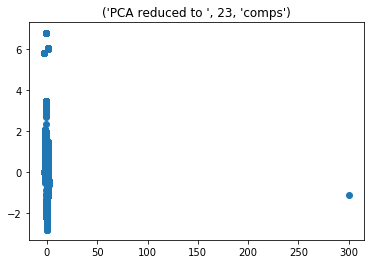

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.015s...
[t-SNE] Computed neighbors for 10176 samples in 7.836s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.279200
[t-SNE] KL divergence after 250 iterations with early exaggera

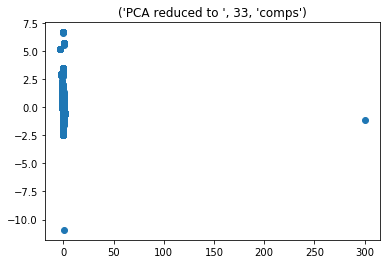

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.020s...
[t-SNE] Computed neighbors for 10176 samples in 12.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.329137
[t-SNE] KL divergence after 250 iterations with early exagger

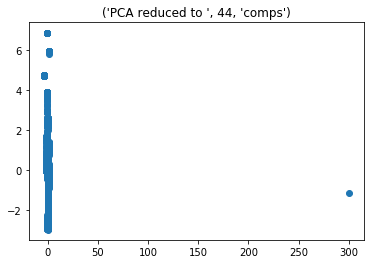

In [199]:
plot_various_PCA(diabetes_x,44, 5 )

#### Note: Performance vs. Components

mice dataset

In [27]:
x_mice_scaled.shape
pca1 =PCA(n_components=77)
pca1.fit(x_mice_scaled)

PCA(copy=True, iterated_power='auto', n_components=77, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
eigeVectors1 = pca1.components_
eigenValues1 = pca1.explained_variance_

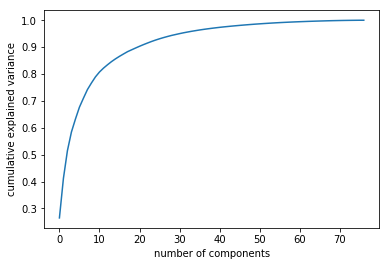

In [29]:
p3_plot.pca_num_components_plot(pca1)

In [30]:
np.cumsum(pca1.explained_variance_ratio_[0:9]) # first 22 components

array([ 0.26455587,  0.41172145,  0.51485834,  0.58417559,  0.63228424,
        0.67667379,  0.71009102,  0.74220344,  0.76666285])

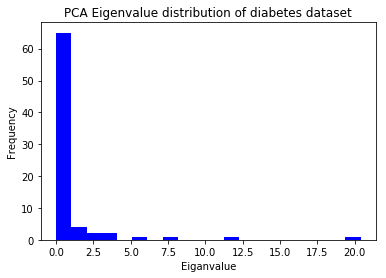

In [31]:
p3_plot.plot_eigenvalue_distribution(eigenValues1,20)

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.000s...
[t-SNE] Computed neighbors for 1080 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 0.706679
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.228321
[t-SNE] Error after 500 iterations: 0.466347
plotting


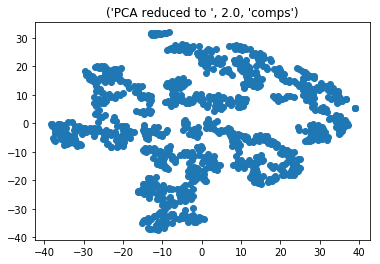

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.001s...
[t-SNE] Computed neighbors for 1080 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.194218
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.507118
[t-SNE] Error after 500 iterations: 0.555600
plotting


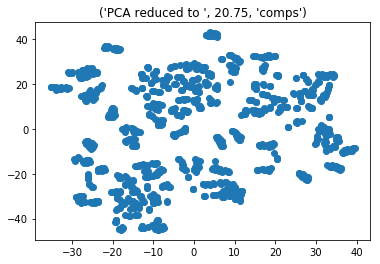

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.001s...
[t-SNE] Computed neighbors for 1080 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.509102
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.812363
[t-SNE] Error after 500 iterations: 0.546440
plotting


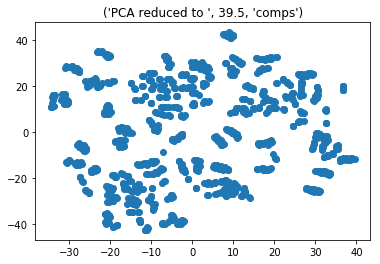

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.002s...
[t-SNE] Computed neighbors for 1080 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.565177
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.930893
[t-SNE] Error after 500 iterations: 0.547616
plotting


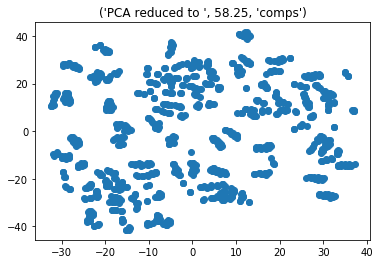

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.002s...
[t-SNE] Computed neighbors for 1080 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.582252
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.942055
[t-SNE] Error after 500 iterations: 0.552400
plotting


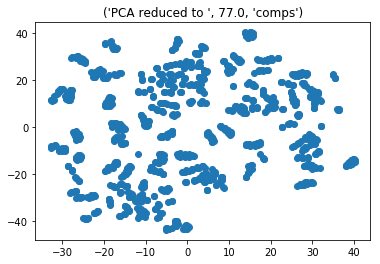

In [196]:
plot_various_PCA(x_mice_scaled,77, 5 )

# RP

In [28]:
def plot_various_RP(data, maxFeatures, steps, n_iters=1000):
    comps = np.linspace(2,maxFeatures, steps)
    for i in comps:
        print('applying PCA')
        pca = GaussianRandomProjection(n_components= int(i))
        trans = pca.fit_transform(data)
        print('applying TSNE')
        tsne = TSNE(2, init='pca', random_state=0, verbose=1, n_iter=n_iters)
        Y = tsne.fit_transform(trans)
        print('plotting')
        plt.figure()
        plt.title(('RP reduced to ',int(i), 'comps'))
        plt.scatter(Y[:, 0], Y[:, 1],cmap=plt.cm.Spectral)
        plt.show()

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.001s...
[t-SNE] Computed neighbors for 1080 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 1.044850
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.967876
[t-SNE] Error after 1000 iterations: 0.485395
plotting


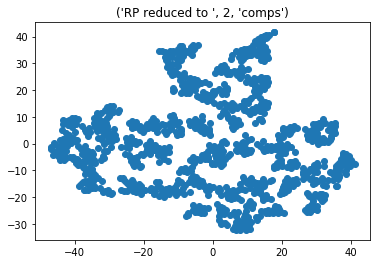

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.001s...
[t-SNE] Computed neighbors for 1080 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.185571
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.342117
[t-SNE] Error after 1000 iterations: 0.672225
plotting


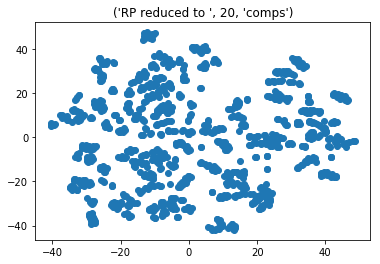

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.001s...
[t-SNE] Computed neighbors for 1080 samples in 0.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.143863
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.013954
[t-SNE] Error after 1000 iterations: 0.544113
plotting


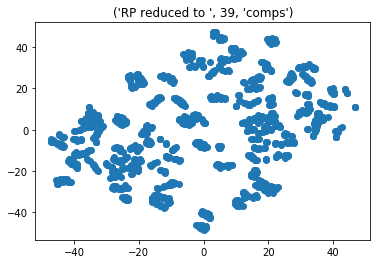

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.001s...
[t-SNE] Computed neighbors for 1080 samples in 0.102s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.500957
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.172684
[t-SNE] Error after 1000 iterations: 0.589178
plotting


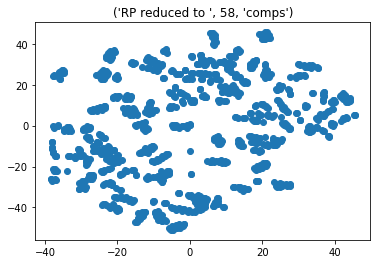

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.003s...
[t-SNE] Computed neighbors for 1080 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.480002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.096977
[t-SNE] Error after 1000 iterations: 0.597005
plotting


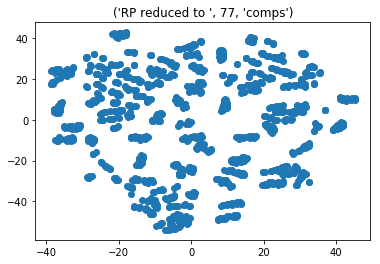

In [206]:
plot_various_RP(x_mice_scaled,77, 5 )

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.019s...
[t-SNE] Computed neighbors for 1080 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 0.839449
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.083710
[t-SNE] Error after 1000 iterations: 0.485479
plotting


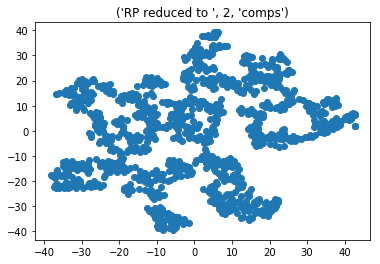

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.001s...
[t-SNE] Computed neighbors for 1080 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.325891
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.042778
[t-SNE] Error after 1000 iterations: 0.674950
plotting


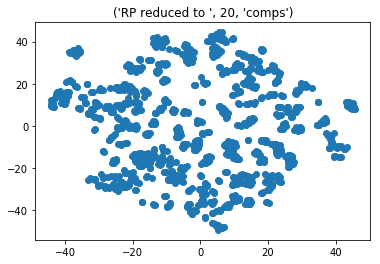

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.002s...
[t-SNE] Computed neighbors for 1080 samples in 0.101s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.491301
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.702324
[t-SNE] Error after 1000 iterations: 0.574016
plotting


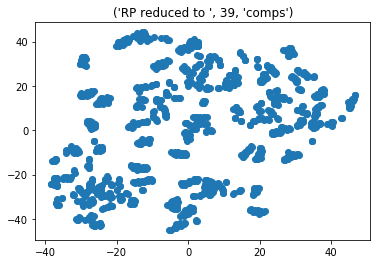

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.002s...
[t-SNE] Computed neighbors for 1080 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.431711
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.788315
[t-SNE] Error after 1000 iterations: 0.566961
plotting


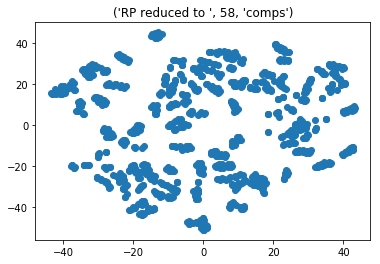

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.003s...
[t-SNE] Computed neighbors for 1080 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.520504
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.490028
[t-SNE] Error after 1000 iterations: 0.572026
plotting


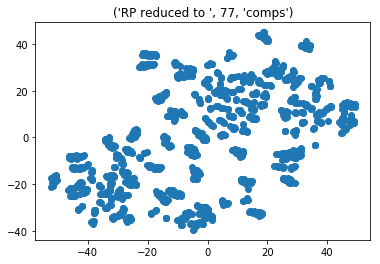

In [29]:
plot_various_RP(x_mice_scaled,77, 5 )

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.001s...
[t-SNE] Computed neighbors for 1080 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 0.912514
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.422173
[t-SNE] Error after 1000 iterations: 0.467676
plotting


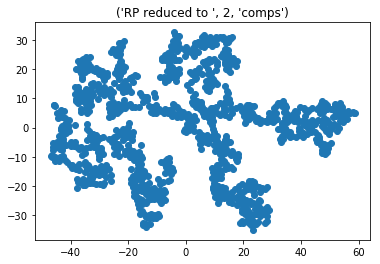

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.001s...
[t-SNE] Computed neighbors for 1080 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.249568
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.138031
[t-SNE] Error after 1000 iterations: 0.638333
plotting


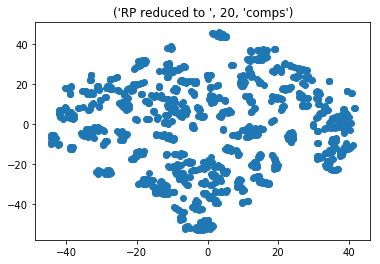

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.001s...
[t-SNE] Computed neighbors for 1080 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.392368
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.516525
[t-SNE] Error after 1000 iterations: 0.617982
plotting


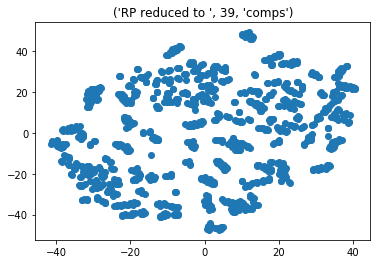

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.002s...
[t-SNE] Computed neighbors for 1080 samples in 0.104s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.543522
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.850067
[t-SNE] Error after 1000 iterations: 0.520060
plotting


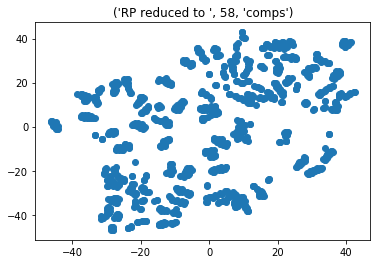

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1080 samples in 0.003s...
[t-SNE] Computed neighbors for 1080 samples in 0.119s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1080
[t-SNE] Computed conditional probabilities for sample 1080 / 1080
[t-SNE] Mean sigma: 3.527829
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.584030
[t-SNE] Error after 1000 iterations: 0.618532
plotting


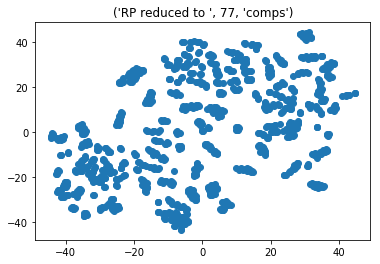

In [30]:
plot_various_RP(x_mice_scaled,77, 5 )

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.005s...
[t-SNE] Computed neighbors for 10176 samples in 0.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 0.225328
[t-SNE] KL divergence after 250 iterations with early exaggera

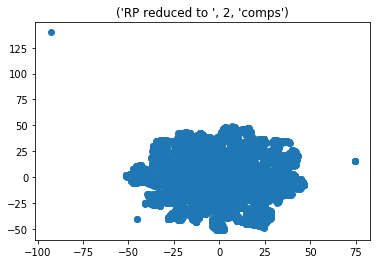

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.008s...
[t-SNE] Computed neighbors for 10176 samples in 2.847s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.061434
[t-SNE] KL divergence after 250 iterations with early exaggera

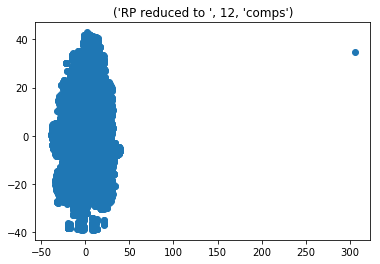

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.013s...
[t-SNE] Computed neighbors for 10176 samples in 4.471s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.239921
[t-SNE] KL divergence after 250 iterations with early exaggera

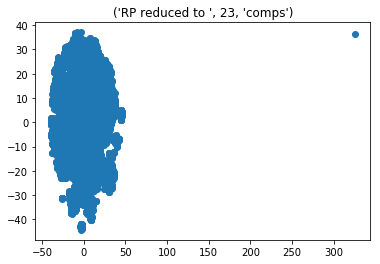

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.025s...
[t-SNE] Computed neighbors for 10176 samples in 6.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.250698
[t-SNE] KL divergence after 250 iterations with early exaggera

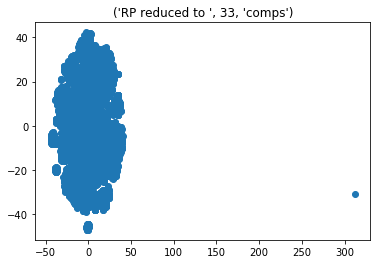

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.027s...
[t-SNE] Computed neighbors for 10176 samples in 10.499s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.256368
[t-SNE] KL divergence after 250 iterations with early exagger

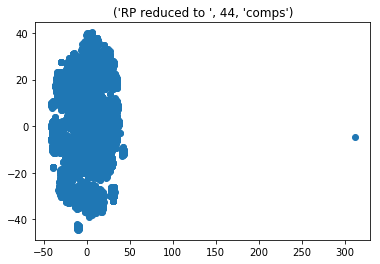

In [31]:
plot_various_RP(diabetes_x,44, 5, n_iters=500 )

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.005s...
[t-SNE] Computed neighbors for 10176 samples in 0.727s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 0.246220
[t-SNE] KL divergence after 250 iterations with early exaggera

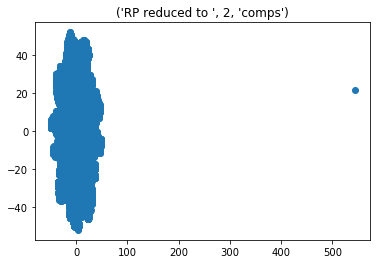

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.013s...
[t-SNE] Computed neighbors for 10176 samples in 2.971s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.179430
[t-SNE] KL divergence after 250 iterations with early exaggera

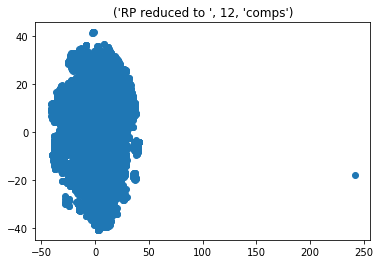

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.012s...
[t-SNE] Computed neighbors for 10176 samples in 3.678s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.158296
[t-SNE] KL divergence after 250 iterations with early exaggera

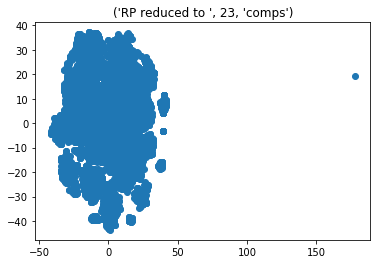

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.013s...
[t-SNE] Computed neighbors for 10176 samples in 5.228s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.205032
[t-SNE] KL divergence after 250 iterations with early exaggera

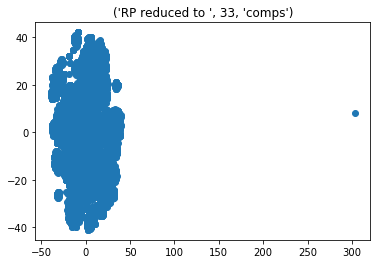

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.020s...
[t-SNE] Computed neighbors for 10176 samples in 13.735s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.242187
[t-SNE] KL divergence after 250 iterations with early exagger

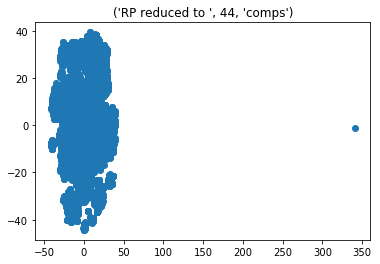

In [32]:
plot_various_RP(diabetes_x,44, 5, n_iters=500 )

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.005s...
[t-SNE] Computed neighbors for 10176 samples in 0.919s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 0.178085
[t-SNE] KL divergence after 250 iterations with early exaggera

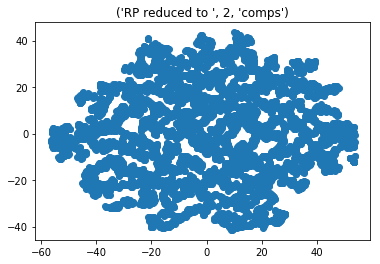

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.008s...
[t-SNE] Computed neighbors for 10176 samples in 2.667s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 0.996265
[t-SNE] KL divergence after 250 iterations with early exaggera

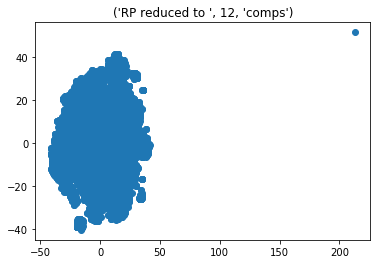

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.011s...
[t-SNE] Computed neighbors for 10176 samples in 3.681s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.100438
[t-SNE] KL divergence after 250 iterations with early exaggera

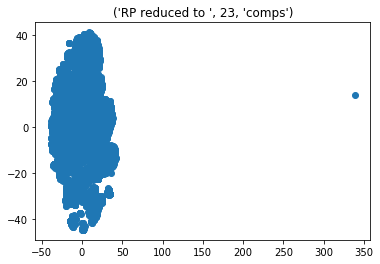

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.018s...
[t-SNE] Computed neighbors for 10176 samples in 5.618s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.234917
[t-SNE] KL divergence after 250 iterations with early exaggera

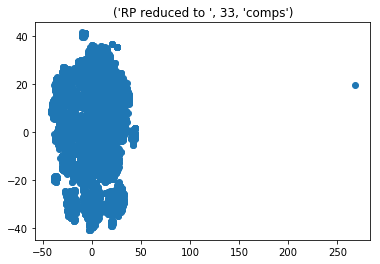

applying PCA
applying TSNE
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10176 samples in 0.016s...
[t-SNE] Computed neighbors for 10176 samples in 9.957s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10176
[t-SNE] Computed conditional probabilities for sample 2000 / 10176
[t-SNE] Computed conditional probabilities for sample 3000 / 10176
[t-SNE] Computed conditional probabilities for sample 4000 / 10176
[t-SNE] Computed conditional probabilities for sample 5000 / 10176
[t-SNE] Computed conditional probabilities for sample 6000 / 10176
[t-SNE] Computed conditional probabilities for sample 7000 / 10176
[t-SNE] Computed conditional probabilities for sample 8000 / 10176
[t-SNE] Computed conditional probabilities for sample 9000 / 10176
[t-SNE] Computed conditional probabilities for sample 10000 / 10176
[t-SNE] Computed conditional probabilities for sample 10176 / 10176
[t-SNE] Mean sigma: 1.242071
[t-SNE] KL divergence after 250 iterations with early exaggera

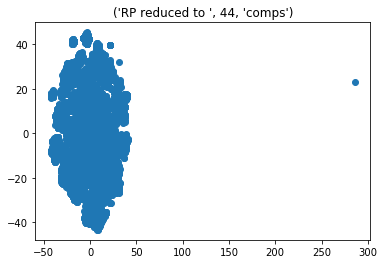

In [208]:
plot_various_RP(diabetes_x,44, 5, n_iters=500 )

# AutoEncoder

mice

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_mice_scaled, y_mice, test_size=0.33, random_state=42)


In [109]:
# def autoEncoderStuff(input_dim, x_train, x_test, num_hidden_layers=1):
#     input_dim = x_train.shape[1]
#     encoding_dim = input_dim
#     print(encoding_dim)

#     input_layer = Input(shape=(input_dim, ))
#     encoder = Dense(encoding_dim, activation="relu", 
#                     activity_regularizer=regularizers.l1(10e-5))(input_layer)
#     if(num_hidden_layers >1):
#         encoder = Dense(int(encoding_dim / 2), activation="sigmoid")(encoder)
#     if(num_hidden_layers >2):
#         encoder = Dense(int(encoding_dim / 2), activation="sigmoid")(encoder)
#     decoder = Dense(int(encoding_dim / 2), activation='sigmoid')(encoder)
#     decoder = Dense(input_dim, activation='relu')(decoder)
#     autoencoder = Model(inputs=input_layer, outputs=decoder)
#     nb_epoch = 100
#     nb_epoch = 100
#     batch_size = 32
#     autoencoder.compile(optimizer='adam', 
#                         loss='mean_squared_error', 
#                         metrics=['accuracy'])
#     checkpointer = ModelCheckpoint(filepath="model.h5",
#                                    verbose=0,
#                                    save_best_only=True)
#     tensorboard = TensorBoard(log_dir='./logs',
#                               histogram_freq=0,
#                               write_graph=True,
#                               write_images=True)
#     history = autoencoder.fit(x_train, x_train,
#                         epochs=nb_epoch,
#                         batch_size=batch_size,
#                         shuffle=True,
#                         validation_data=(x_test, x_test),
#                         verbose=1,
#                     callbacks=[checkpointer, tensorboard]).history
#     plt.plot(history['loss'])
#     plt.plot(history['val_loss'])
#     plt.title('model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper right');
#     plt.show()
    
#     predictions = autoencoder.predict(x_test)
#     sparcity = ((np.count_nonzero(predictions==0))/predictions.size)*100
#     return (predictions,sparcity)

77
Train on 723 samples, validate on 357 samples
Epoch 1/100
723/723 [==============================] - 0s - loss: 1.0949 - acc: 0.0069 - val_loss: 1.0993 - val_acc: 0.0196
Epoch 2/100
723/723 [==============================] - 0s - loss: 1.0097 - acc: 0.0332 - val_loss: 1.0559 - val_acc: 0.0476
Epoch 3/100
723/723 [==============================] - 0s - loss: 0.9724 - acc: 0.0429 - val_loss: 1.0231 - val_acc: 0.0448
Epoch 4/100
723/723 [==============================] - 0s - loss: 0.9421 - acc: 0.0526 - val_loss: 0.9949 - val_acc: 0.0532
Epoch 5/100
723/723 [==============================] - 0s - loss: 0.9147 - acc: 0.0539 - val_loss: 0.9695 - val_acc: 0.0644
Epoch 6/100
723/723 [==============================] - 0s - loss: 0.8909 - acc: 0.0692 - val_loss: 0.9482 - val_acc: 0.0728
Epoch 7/100
723/723 [==============================] - 0s - loss: 0.8712 - acc: 0.0871 - val_loss: 0.9313 - val_acc: 0.0868
Epoch 8/100
723/723 [==============================] - 0s - loss: 0.8550 - acc: 0.0

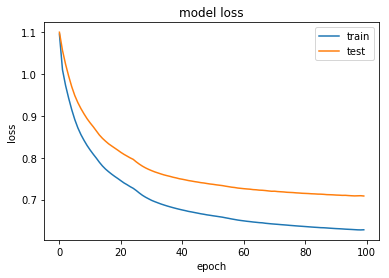

In [25]:
mice_1=p3_plot.autoEncoderStuff(77, x_train, x_test, num_hidden_layers=1)


77
Train on 723 samples, validate on 357 samples
Epoch 1/100
723/723 [==============================] - 0s - loss: 1.0885 - acc: 0.0069 - val_loss: 1.1114 - val_acc: 0.0084
Epoch 2/100
723/723 [==============================] - 0s - loss: 1.0344 - acc: 0.0207 - val_loss: 1.0871 - val_acc: 0.0196
Epoch 3/100
723/723 [==============================] - 0s - loss: 1.0166 - acc: 0.0221 - val_loss: 1.0753 - val_acc: 0.0140
Epoch 4/100
723/723 [==============================] - 0s - loss: 1.0055 - acc: 0.0290 - val_loss: 1.0647 - val_acc: 0.0252
Epoch 5/100
723/723 [==============================] - 0s - loss: 0.9951 - acc: 0.0290 - val_loss: 1.0544 - val_acc: 0.0196
Epoch 6/100
723/723 [==============================] - 0s - loss: 0.9851 - acc: 0.0401 - val_loss: 1.0442 - val_acc: 0.0336
Epoch 7/100
723/723 [==============================] - 0s - loss: 0.9754 - acc: 0.0429 - val_loss: 1.0353 - val_acc: 0.0560
Epoch 8/100
723/723 [==============================] - 0s - loss: 0.9670 - acc: 0.0

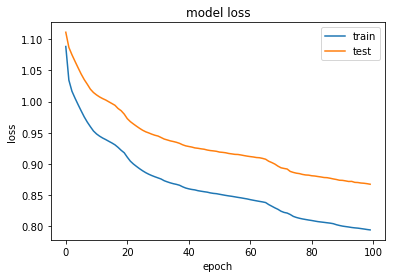

In [26]:
mice_2 = p3_plot.autoEncoderStuff(77, x_train, x_test, num_hidden_layers=2)

77
Train on 723 samples, validate on 357 samples
Epoch 1/100
723/723 [==============================] - 0s - loss: 1.0903 - acc: 0.0041 - val_loss: 1.1119 - val_acc: 0.0028
Epoch 2/100
723/723 [==============================] - 0s - loss: 1.0352 - acc: 0.0041 - val_loss: 1.0900 - val_acc: 0.0140
Epoch 3/100
723/723 [==============================] - 0s - loss: 1.0206 - acc: 0.0166 - val_loss: 1.0806 - val_acc: 0.0056
Epoch 4/100
723/723 [==============================] - 0s - loss: 1.0117 - acc: 0.0194 - val_loss: 1.0730 - val_acc: 0.0112
Epoch 5/100
723/723 [==============================] - 0s - loss: 1.0052 - acc: 0.0111 - val_loss: 1.0672 - val_acc: 0.0196
Epoch 6/100
723/723 [==============================] - 0s - loss: 0.9998 - acc: 0.0249 - val_loss: 1.0624 - val_acc: 0.0168
Epoch 7/100
723/723 [==============================] - 0s - loss: 0.9958 - acc: 0.0124 - val_loss: 1.0585 - val_acc: 0.0112
Epoch 8/100
723/723 [==============================] - 0s - loss: 0.9922 - acc: 0.0

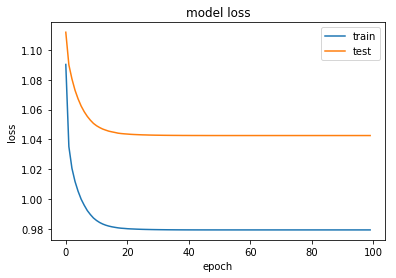

In [27]:
mice_3 = p3_plot.autoEncoderStuff(77, x_train, x_test, num_hidden_layers=3)

In [97]:
# def plot_autoEncoder_projections(title,data):
#     tsne = TSNE(2, init='pca', random_state=0, verbose=1, n_iter=500)
#     Y = tsne.fit_transform(data)
#     print('plotting')
#     plt.figure()
#     plt.title(title)
#     plt.scatter(Y[:, 0], Y[:, 1],cmap=plt.cm.Spectral)
#     plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 357 samples in 0.001s...
[t-SNE] Computed neighbors for 357 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 357 / 357
[t-SNE] Mean sigma: 1.414230
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.281815
[t-SNE] Error after 500 iterations: 0.691339
plotting


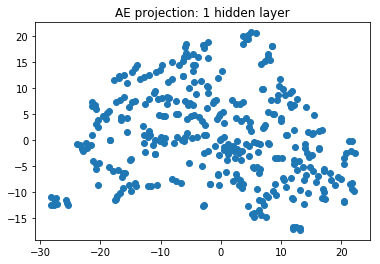

In [29]:
p3_plot. plot_autoEncoder_projections('AE projection: 1 hidden layer',mice_1[0])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 357 samples in 0.001s...
[t-SNE] Computed neighbors for 357 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 357 / 357
[t-SNE] Mean sigma: 0.644454
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.173992
[t-SNE] Error after 500 iterations: 0.479095
plotting


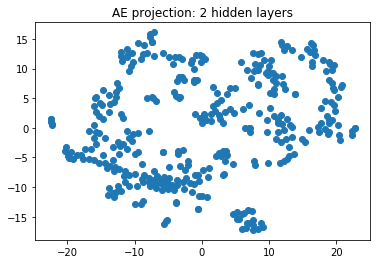

In [30]:
p3_plot.plot_autoEncoder_projections('AE projection: 2 hidden layers',mice_2[0])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 357 samples in 0.001s...
[t-SNE] Computed neighbors for 357 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 357 / 357
[t-SNE] Mean sigma: 0.000000


/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/pca.py:505: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


[t-SNE] KL divergence after 50 iterations with early exaggeration: -533.377014
[t-SNE] Error after 100 iterations: -46.930264
plotting


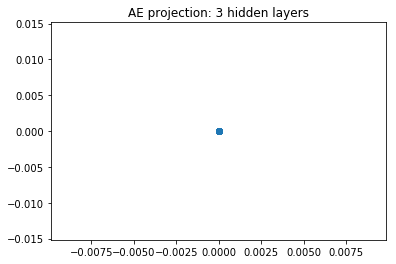

In [31]:
p3_plot.plot_autoEncoder_projections('AE projection: 3 hidden layers',mice_3[0])

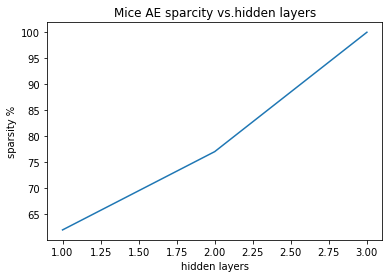

In [91]:
plt.plot([1,2,3],[mice_1[1], mice_2[1], mice_3[1]])
plt.title('Mice AE sparcity vs.hidden layers')
plt.xlabel('hidden layers')
plt.ylabel('sparsity %')

Diabetes

In [32]:
x_train, x_test, y_train, y_test = train_test_split(diabetes_x, diabetes_y, test_size=0.33, random_state=42)


44
Train on 6817 samples, validate on 3359 samples
Epoch 1/100
6817/6817 [==============================] - 0s - loss: 1.1435 - acc: 0.1788 - val_loss: 0.7137 - val_acc: 0.3209
Epoch 2/100
6817/6817 [==============================] - 0s - loss: 1.0721 - acc: 0.3591 - val_loss: 0.6579 - val_acc: 0.4332
Epoch 3/100
6817/6817 [==============================] - 0s - loss: 1.0251 - acc: 0.4484 - val_loss: 0.6172 - val_acc: 0.4868
Epoch 4/100
6817/6817 [==============================] - 0s - loss: 0.9910 - acc: 0.4985 - val_loss: 0.5879 - val_acc: 0.5341
Epoch 5/100
6817/6817 [==============================] - 0s - loss: 0.9655 - acc: 0.5293 - val_loss: 0.5611 - val_acc: 0.5531
Epoch 6/100
6817/6817 [==============================] - 0s - loss: 0.9409 - acc: 0.5519 - val_loss: 0.5418 - val_acc: 0.5728
Epoch 7/100
6817/6817 [==============================] - 0s - loss: 0.9245 - acc: 0.5642 - val_loss: 0.5278 - val_acc: 0.5799
Epoch 8/100
6817/6817 [==============================] - 0s - loss:

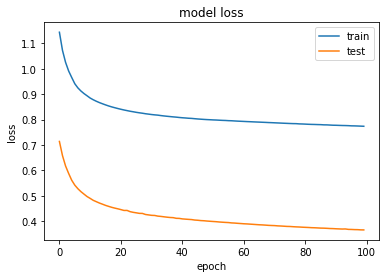

In [33]:
diabetes_1=p3_plot.autoEncoderStuff(44, x_train, x_test, num_hidden_layers=1)


44
Train on 6817 samples, validate on 3359 samples
Epoch 1/100
6817/6817 [==============================] - 0s - loss: 1.1592 - acc: 0.0810 - val_loss: 0.7548 - val_acc: 0.1292
Epoch 2/100
6817/6817 [==============================] - 0s - loss: 1.1331 - acc: 0.1262 - val_loss: 0.7427 - val_acc: 0.1218
Epoch 3/100
6817/6817 [==============================] - 0s - loss: 1.1188 - acc: 0.1521 - val_loss: 0.7271 - val_acc: 0.1539
Epoch 4/100
6817/6817 [==============================] - 0s - loss: 1.1047 - acc: 0.1749 - val_loss: 0.7160 - val_acc: 0.1753
Epoch 5/100
6817/6817 [==============================] - 0s - loss: 1.0953 - acc: 0.1857 - val_loss: 0.7069 - val_acc: 0.2135
Epoch 6/100
6817/6817 [==============================] - 0s - loss: 1.0859 - acc: 0.2284 - val_loss: 0.6964 - val_acc: 0.2745
Epoch 7/100
6817/6817 [==============================] - 0s - loss: 1.0757 - acc: 0.2570 - val_loss: 0.6862 - val_acc: 0.2614
Epoch 8/100
6817/6817 [==============================] - 0s - loss:

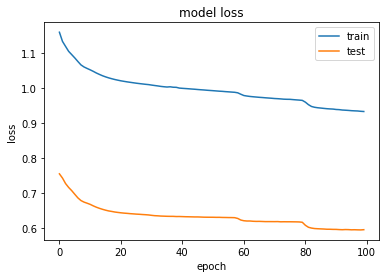

In [34]:
diabetes_2=p3_plot.autoEncoderStuff(44, x_train, x_test, num_hidden_layers=2)


44
Train on 6817 samples, validate on 3359 samples
Epoch 1/100
6817/6817 [==============================] - 0s - loss: 1.1644 - acc: 0.0606 - val_loss: 0.7556 - val_acc: 0.0557
Epoch 2/100
6817/6817 [==============================] - 0s - loss: 1.1371 - acc: 0.0368 - val_loss: 0.7497 - val_acc: 0.0304
Epoch 3/100
6817/6817 [==============================] - 0s - loss: 1.1344 - acc: 0.0200 - val_loss: 0.7482 - val_acc: 0.0652
Epoch 4/100
6817/6817 [==============================] - 0s - loss: 1.1323 - acc: 0.0409 - val_loss: 0.7452 - val_acc: 0.0137
Epoch 5/100
6817/6817 [==============================] - 0s - loss: 1.1283 - acc: 0.0238 - val_loss: 0.7404 - val_acc: 0.0152
Epoch 6/100
6817/6817 [==============================] - 0s - loss: 1.1236 - acc: 0.0317 - val_loss: 0.7358 - val_acc: 0.0137
Epoch 7/100
6817/6817 [==============================] - 0s - loss: 1.1200 - acc: 0.0292 - val_loss: 0.7329 - val_acc: 0.0304
Epoch 8/100
6817/6817 [==============================] - 0s - loss:

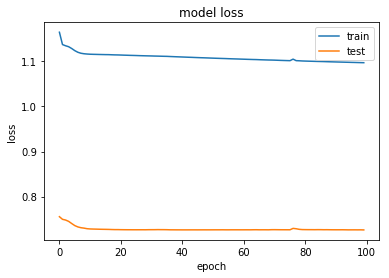

In [35]:
diabetes_3=p3_plot.autoEncoderStuff(44, x_train, x_test, num_hidden_layers=3)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3359 samples in 0.025s...
[t-SNE] Computed neighbors for 3359 samples in 0.764s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3359
[t-SNE] Computed conditional probabilities for sample 2000 / 3359
[t-SNE] Computed conditional probabilities for sample 3000 / 3359
[t-SNE] Computed conditional probabilities for sample 3359 / 3359
[t-SNE] Mean sigma: 0.698112
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.003693
[t-SNE] Error after 500 iterations: 0.954695
plotting


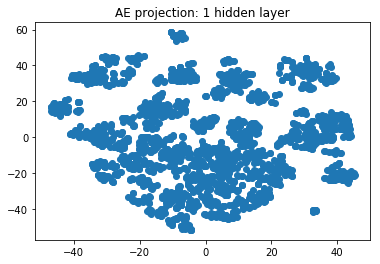

In [40]:
p3_plot. plot_autoEncoder_projections('AE projection: 1 hidden layer',diabetes_1[0])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3359 samples in 0.017s...
[t-SNE] Computed neighbors for 3359 samples in 0.665s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3359
[t-SNE] Computed conditional probabilities for sample 2000 / 3359
[t-SNE] Computed conditional probabilities for sample 3000 / 3359
[t-SNE] Computed conditional probabilities for sample 3359 / 3359
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.975658
[t-SNE] Error after 500 iterations: 0.488642
plotting


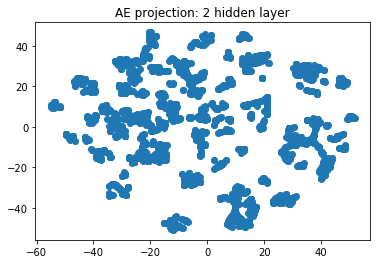

In [43]:
p3_plot. plot_autoEncoder_projections('AE projection: 2 hidden layer',diabetes_2[0])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3359 samples in 0.017s...
[t-SNE] Computed neighbors for 3359 samples in 0.646s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3359
[t-SNE] Computed conditional probabilities for sample 2000 / 3359
[t-SNE] Computed conditional probabilities for sample 3000 / 3359
[t-SNE] Computed conditional probabilities for sample 3359 / 3359
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.312035
[t-SNE] Error after 500 iterations: 0.190623
plotting


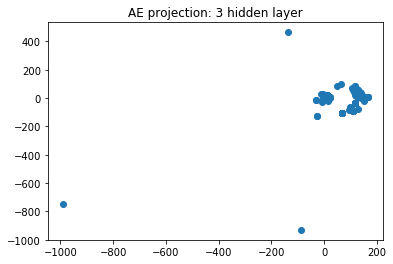

In [44]:
p3_plot. plot_autoEncoder_projections('AE projection: 3 hidden layer',diabetes_3[0])

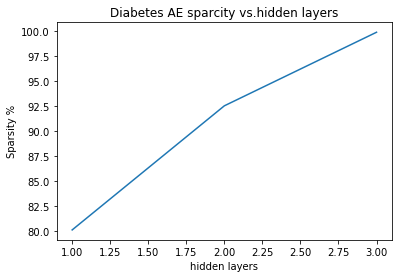

In [90]:
plt.plot([1,2,3],[diabetes_1[1], diabetes_2[1], diabetes_3[1]])
plt.title('Diabetes AE sparcity vs.hidden layers')
plt.xlabel('hidden layers')
plt.ylabel('Sparsity %')

# Rerunning Clustering

In [98]:
reducedPCAMice = PCA(n_components=23).fit_transform(x_mice_scaled)
reducedRPMice = GaussianRandomProjection(n_components=23).fit_transform(x_mice_scaled)
reducedAEMice = mice_2[0]

reducedPCADiabets = PCA(n_components=28).fit_transform(diabetes_x)
reducedRPDiabets = GaussianRandomProjection(n_components=23).fit_transform(diabetes_x)
reducedAEDiabetes = diabetes_2[0]

pac_arr = [reducedPCAMice, reducedPCADiabets]
rp_arr = [reducedRPMice, reducedRPDiabets]
ae_arr = [reducedAEMice, reducedAEDiabetes]
    

PCA Mice

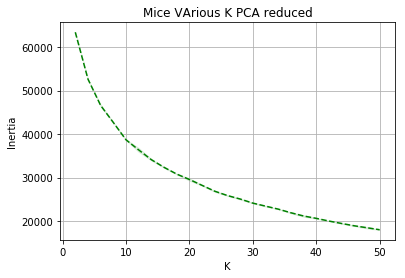

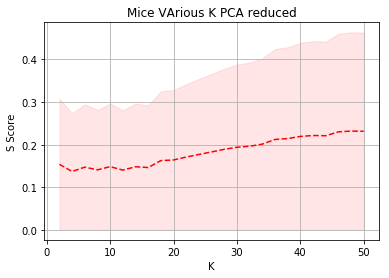

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [60]:
p3_plot.plot_various_k('Mice VArious K PCA reduced',reducedPCAMice, min_k=2, max_k=50, step_size=25)

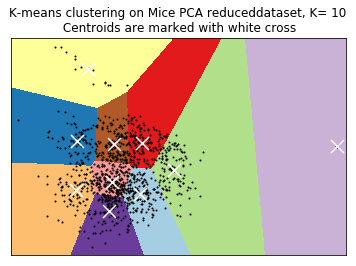

<function matplotlib.pyplot.show>

In [58]:
p3_plot.plot_kmeans_1('Mice PCA reduced',reducedPCAMice, 10)
plt.show

<module 'matplotlib.pyplot' from '/Users/Tiera/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

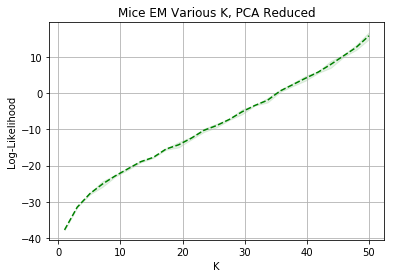

In [49]:
p3_plot. plot_various_k_EM('Mice EM Various K, PCA Reduced', reducedPCAMice, min_k=1, max_k=50, step_size=25)

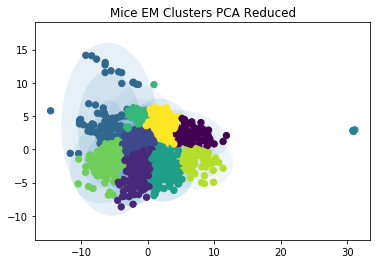

In [118]:
p3_plot.plot_gmm('Mice EM Clusters PCA Reduced',GaussianMixture(n_components=10), reducedPCAMice)

RP Mice

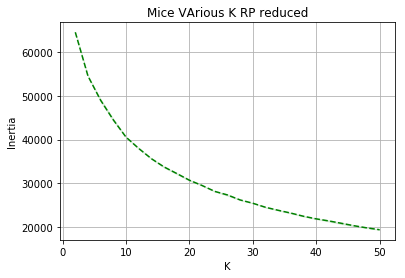

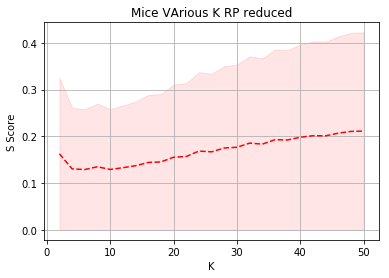

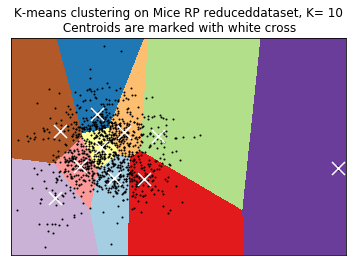

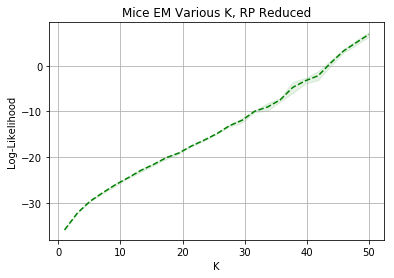

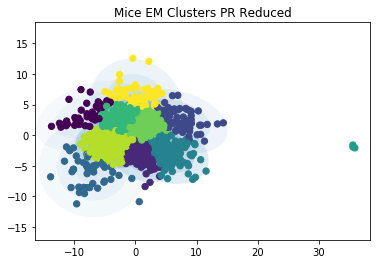

In [68]:
p3_plot.plot_various_k('Mice VArious K RP reduced',reducedRPMice, min_k=2, max_k=50, step_size=25)
p3_plot.plot_kmeans_1('Mice RP reduced',reducedRPMice, 10)
p3_plot. plot_various_k_EM('Mice EM Various K, RP Reduced', reducedRPMice, min_k=1, max_k=50, step_size=25)
plt.figure()
p3_plot.plot_gmm('Mice EM Clusters PR Reduced',GaussianMixture(n_components=10), reducedRPMice)


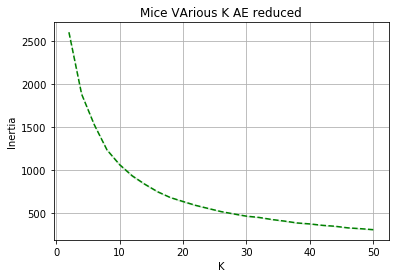

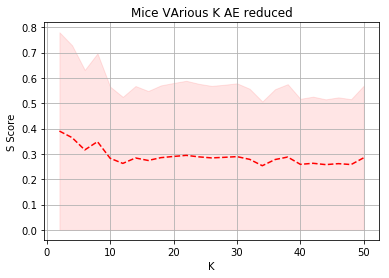

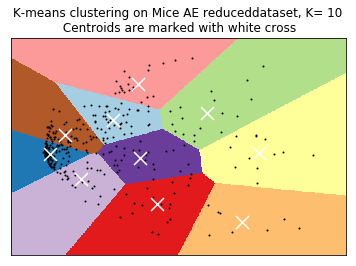

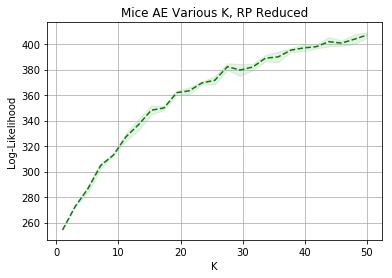

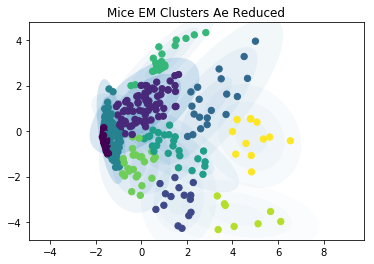

In [70]:
p3_plot.plot_various_k('Mice VArious K AE reduced',reducedAEMice, min_k=2, max_k=50, step_size=25)
p3_plot.plot_kmeans_1('Mice AE reduced',reducedAEMice, 10)
p3_plot. plot_various_k_EM('Mice AE Various K, RP Reduced', reducedAEMice, min_k=1, max_k=50, step_size=25)
plt.figure()
p3_plot.plot_gmm('Mice EM Clusters Ae Reduced',GaussianMixture(n_components=10), reducedAEMice)

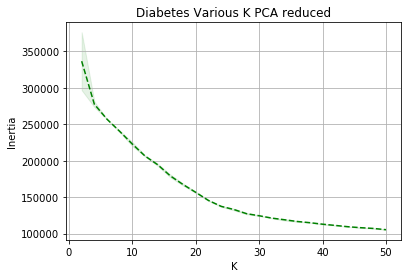

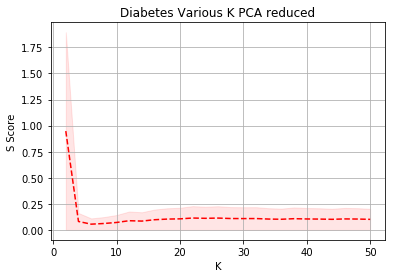

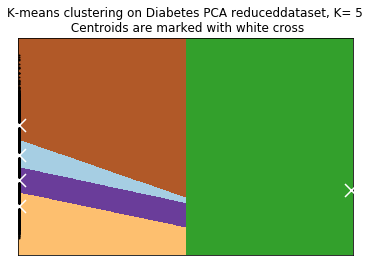

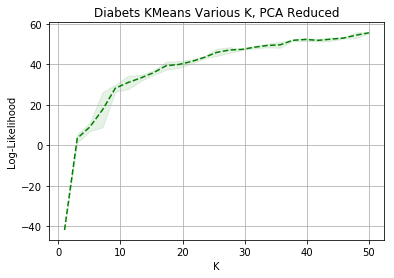

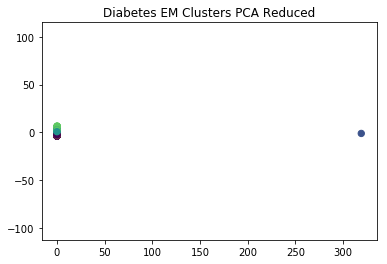

In [71]:
p3_plot.plot_various_k('Diabetes Various K PCA reduced',reducedPCADiabets, min_k=2, max_k=50, step_size=25)
p3_plot.plot_kmeans_1('Diabetes PCA reduced',reducedPCADiabets, 5)
p3_plot. plot_various_k_EM('Diabets KMeans Various K, PCA Reduced', reducedPCADiabets, min_k=1, max_k=50, step_size=25)
plt.figure()
p3_plot.plot_gmm('Diabetes EM Clusters PCA Reduced',GaussianMixture(n_components=5), reducedPCADiabets)

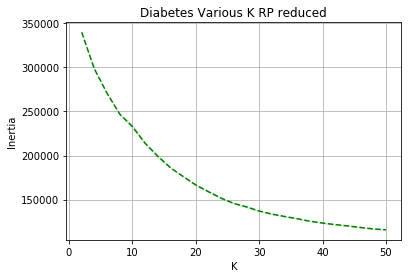

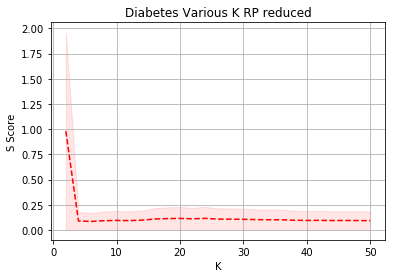

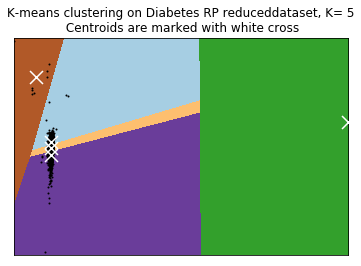

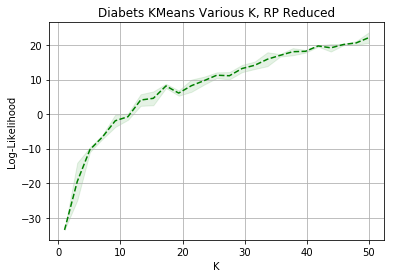

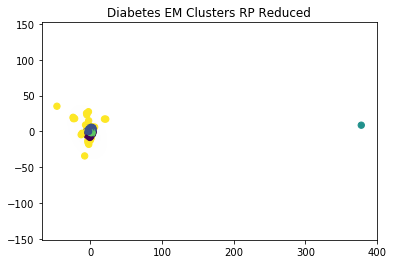

In [119]:
p3_plot.plot_various_k('Diabetes Various K RP reduced',reducedRPDiabets, min_k=2, max_k=50, step_size=25)
p3_plot.plot_kmeans_1('Diabetes RP reduced',reducedRPDiabets, 5)
p3_plot. plot_various_k_EM('Diabets KMeans Various K, RP Reduced', reducedRPDiabets, min_k=1, max_k=50, step_size=25)
plt.figure()
p3_plot.plot_gmm('Diabetes EM Clusters RP Reduced',GaussianMixture(n_components=5), reducedRPDiabets)

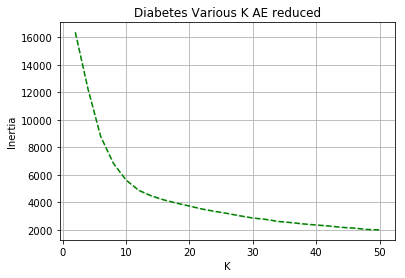

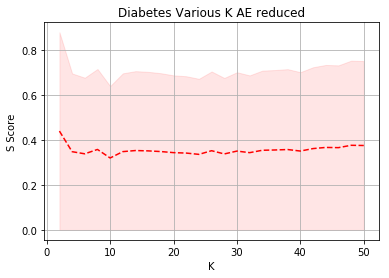

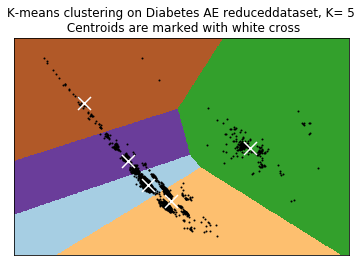

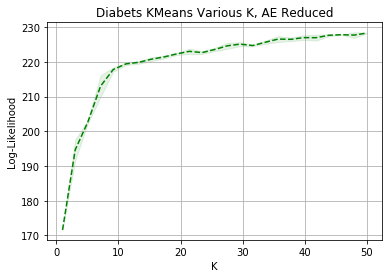

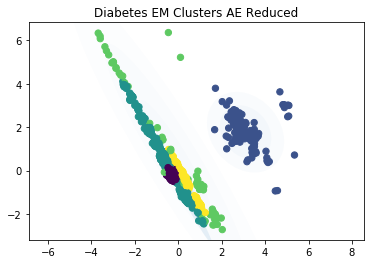

In [121]:
p3_plot.plot_various_k('Diabetes Various K AE reduced',reducedAEDiabetes, min_k=2, max_k=50, step_size=25)
p3_plot.plot_kmeans_1('Diabetes AE reduced',reducedAEDiabetes, 5)
p3_plot. plot_various_k_EM('Diabets KMeans Various K, AE Reduced', reducedAEDiabetes, min_k=1, max_k=50, step_size=25)
plt.figure()
p3_plot.plot_gmm('Diabetes EM Clusters AE Reduced',GaussianMixture(n_components=5), reducedAEDiabetes)

# Running Neural Net from P1

In [73]:
def plot_learning_curve(estimator, title, X, y, ylim=(0,1), cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):


    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, '--', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, '--', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [74]:
def plot_nnet_compare_iters(title, X_arr, Y,names, min_iters = 100, max_iters = 500, step_size= 5, cv=3, ylim=None):
    plt.figure()
    plt.grid()
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    if ylim is not None:
        plt.ylim(*ylim)

    iterations = np.linspace(min_iters, max_iters, step_size)
    for num,X in enumerate(X_arr):
        avg_scores = np.zeros([step_size])
        i=0
        net = MLPClassifier(hidden_layer_sizes = (9,) ,solver = 'sgd', activation ='relu', momentum = 0.9 )
  
        for its in iterations:
            net.set_params(max_iter = int(its))
            scores = cross_val_score(net,X_arr[num] , Y, cv=cv)
            avg_scores[i] = np.mean(scores)
            i += 1
        label = names[num]   
        plt.plot(iterations, avg_scores, '--', label = label)
    plt.legend(loc ='best')
    


In [85]:
x_array = [diabetes_x,reducedPCADiabets,reducedRPDiabets]
x_names = ['Unreduced','PCA','Random Projection']

/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged 

CPU times: user 3min 9s, sys: 14.1 s, total: 3min 24s
Wall time: 3min 19s


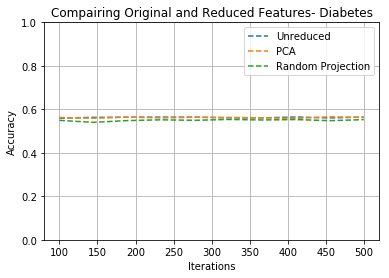

In [86]:
%time plot_nnet_compare_iters('Compairing Original and Reduced Features- Diabetes', x_array, diabetes_y,x_names,step_size=10,ylim=(0,1))

0


/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (121) reached and the optimization hasn't converged 

1


/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (121) reached and the optimization hasn't converged 

2


/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (121) reached and the optimization hasn't converged 

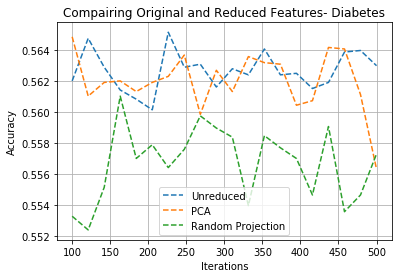

In [30]:
plot_nnet_compare_iters('Compairing Original and Reduced Features- Diabetes', x_array, diabetes_y,x_names, step_size=20)

# Rerun NN with clustering

Kmeans

In [109]:
num_clusters = 5
PCA_centers = KMeans(n_clusters=num_clusters).fit(reducedPCADiabets).cluster_centers_
transformed = PCA(n_components=28).fit_transform(diabetes_x)
PCA_vector = np.zeros([transformed.shape[0],num_clusters])

for i,point in enumerate(transformed):
    PCA_vector[i] = euclidean_distances([point], PCA_centers)

In [110]:
RP = reducedRPDiabets
RP_centers = (KMeans(n_clusters=num_clusters).fit(RP).cluster_centers_)
RP_vector = np.zeros([RP.shape[0],num_clusters])

for i,point in enumerate(RP):
    RP_vector[i] = euclidean_distances([point], RP_centers)

In [111]:
kmeans_arr = [diabetes_x,PCA_vector, RP_vector]

/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (144) reached and the optimization hasn't converged 

CPU times: user 2min 28s, sys: 1.03 s, total: 2min 29s
Wall time: 1min 23s


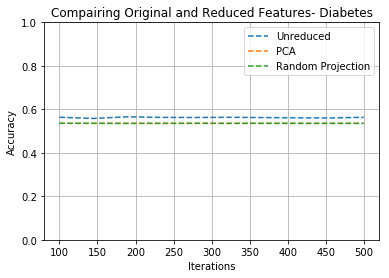

In [183]:

%time plot_nnet_compare_iters('Compairing Original and Reduced Features- Diabetes', kmeans_arr,diabetes_y,x_names, step_size=10,ylim=(0,1))

EM

In [113]:
pca = PCA(n_components=28).fit_transform(diabetes_x)
Pca_centers = GaussianMixture(n_components=5).fit(pca).means_
Pca_vector = np.zeros([transformed.shape[0],5])

for i,point in enumerate(pca):
    PCA_vector[i] = euclidean_distances([point], PCA_centers)
    
RP = GaussianRandomProjection(n_components=29).fit_transform(diabetes_x)
RP_centers = (GaussianMixture(n_components=5).fit(RP).means_)
RP_vector = np.zeros([RP.shape[0],5])

for i,point in enumerate(RP):
    RP_vector[i] = euclidean_distances([point], RP_centers)

In [114]:
kmeans_arr = [diabetes_x,PCA_vector, RP_vector]

/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Tiera/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (144) reached and the optimization hasn't converged 

CPU times: user 1min 46s, sys: 7.67 s, total: 1min 53s
Wall time: 2min 1s


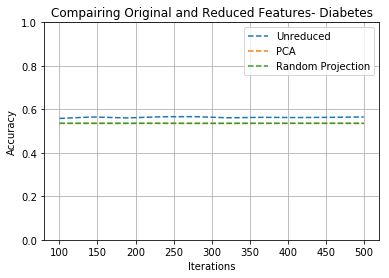

In [115]:
%time plot_nnet_compare_iters('Compairing Original and Reduced Features- Diabetes', kmeans_arr,diabetes_y,x_names, step_size=10,ylim=(0,1))